In [1]:
import gymnasium as gym
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
import copy
 
sys.path.insert(1, '/Users/keithwang/Desktop/Fall 2023/Reinforcement Learning/project/RLevator/')


from RLevator.rlevator.environment import RLevatorEnv
import warnings
warnings.filterwarnings("ignore")

### Environment - Elevator Group Control System

In [2]:
env = RLevatorEnv(num_elevators=3, num_floors=6)
print('State shape: ', env.observation_space.shape)
print('Sample of state: ', env.observation_space.sample())
print('Number of actions: ', env.action_space.shape)
print('Sample of action: ', env.action_space.sample())

State shape:  (48,)
Sample of state:  [0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 0 1 1 1 0 1 0 0 0 1]
Number of actions:  (3,)
Sample of action:  [0 5 4]


In [3]:
# Define MLP policy

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        # XXX NOTE: Commenting this line to avoid conflict with deepcopy
        # self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

### Define some hyperparameter

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.999           # discount factor
LR = 1e-3            # learning rate
UPDATE_EVERY = 4       # how often to update the network
CLONE_EVERY = int(1e3)  # how often to clone the q networks

In [5]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

### Define Agent with multiple Q-networks

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_len, action_size, seed, QNetwork):
        """Initialize an Agent object.

        Args:
            state_size (int): dimension of each state
            action_len (int): dimension of multi-discrete action space
            action_size (int): number of action in each dimension of action space
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_len = action_len
        self.seed = random.seed(seed)

        # Q-Networks, one for each dimension of action space
        self.qnetwork_local_list = []
        self.qnetwork_target_list = []
        for i in range(action_len):
            self.qnetwork_local_list.append(QNetwork(state_size, action_size, seed).to(device))
            self.qnetwork_target_list.append(QNetwork(state_size, action_size, seed).to(device))

        self.optimizer_list = []
        for i in range(action_len):
            self.optimizer_list.append(optim.Adam(self.qnetwork_local_list[i].parameters(), lr=LR))

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def clone(self):
        try:
            for i in range(self.action_len):
                self.qnetwork_target_list[i] = QNetwork(self.state_size, self.action_size, self.seed).to(device)
        except:
            pass

        for i in range(self.action_len):
            self.qnetwork_target_list[i] = copy.deepcopy(self.qnetwork_local_list[i])
            for p in self.qnetwork_target_list[i].parameters():
                p.requires_grad = False
            self.qnetwork_target_list[i] = self.qnetwork_target_list[i].to(device)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step += 1

        if self.t_step % UPDATE_EVERY == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

        if self.t_step % CLONE_EVERY == 0:
            self.clone()


    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Args:
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = np.zeros(self.action_len)
        # generate action for each q-network
        for i in range(self.action_len):
            self.qnetwork_local_list[i].eval()
            with torch.no_grad():
                action_values = self.qnetwork_local_list[i](state)
            self.qnetwork_local_list[i].train()

            # Epsilon-greedy action selection
            if random.random() > eps:
                action[i] = np.argmax(action_values.cpu().data.numpy())
            else:
                action[i] = random.choice(np.arange(self.action_size))
        return action
            

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences
        
        for i in range(self.action_len):
            ## Compute and minimize the loss
            ### Extract next maximum estimated value from target network
            q_targets_next = self.qnetwork_target_list[i](next_states).detach().max(1)[0].unsqueeze(1)
            ### Calculate target value from bellman equation
            q_targets = rewards + gamma * q_targets_next * (1 - dones)
            ### Calculate expected value from local network
            q_expected = self.qnetwork_local_list[i](states).gather(1, actions[:,i].unsqueeze(1))

            ### Loss calculation (we used Mean squared error)
            loss = F.mse_loss(q_expected, q_targets)
            self.optimizer_list[i].zero_grad()
            loss.backward()
            self.optimizer_list[i].step()

### Define Replay Buffer

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Args:
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Training Process

In [8]:
def dqn(n_episodes=800, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent=None):
    """Deep Q-Learning.

    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores


## Tuning Hyperparameters

In [9]:
dqn_agent = Agent(state_size=48, action_len=3, action_size=6, seed=0, QNetwork=QNetwork)
dqn_scores = dqn(agent=dqn_agent)

Episode 100	Average Score: -11860.44
Episode 200	Average Score: 15085.944
Episode 300	Average Score: 20316.14
Episode 400	Average Score: 22969.11
Episode 500	Average Score: 23902.29
Episode 600	Average Score: 24202.96
Episode 700	Average Score: 24421.92
Episode 800	Average Score: 24517.62


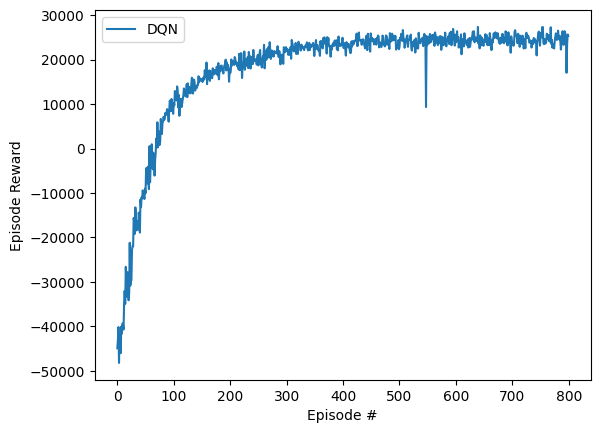

In [10]:
plt.plot(dqn_scores, label='DQN')
plt.legend()
plt.ylabel('Episode Reward')
plt.xlabel('Episode #')
plt.savefig('dqn.png')